In [117]:
from os import path
import importlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
_ = torch.manual_seed(1)

In [118]:
import test_data as td
importlib.reload(td)
from test_data import set_test_data

set_test_data(
    data_count=None, 
    moving_av=True,
    verbose=False)

DATA = td.DATA

In [119]:
import tokenizer as to
importlib.reload(to)
from tokenizer import Tokenizer
Tokenizer.set_quantization_levels(*Tokenizer.get_statistics(DATA, bins=100))
whole_story = Tokenizer.get_whole_story(DATA)
word, word_count = Tokenizer.get_words_used(whole_story)

print('word count: ', (Tokenizer.level_count ** 3) * 2 )
print('used word count: ', len(word))
print('most common:\n', word_count[:3])
print('less common:\n', word_count[-3:])


word count:  1024
used word count:  896
most common:
 [((17.1, 0.00528, 0.000146), 352), ((14.3, 0.00528, 0.000146), 323), ((17.1, -0.00568, 0.000146), 248)]
less common:
 [((11.1, -0.00568, 1.82e-05), 13), ((12.5, -0.00568, 1.82e-05), 12), ((9.2, -0.00568, 1.82e-05), 11)]


In [120]:
training_story = whole_story[:(len(whole_story) // 3) * 2]
test_story = whole_story[len(training_story):]
vocabulary = set(whole_story)

Training data preparation

In [121]:
# https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

import torch
import torch.nn as nn
CONTEXT_SIZE = 5  # 2 words to the left, 2 to the right
EMDEDDING_DIM = 10

def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long) 

vocabulary_size = len(vocabulary)
word_to_ix = {word:ix for ix, word in enumerate(vocabulary)}
ix_to_word = {ix:word for ix, word in enumerate(vocabulary)}

training_context = []
for i in range(CONTEXT_SIZE, len(training_story) - CONTEXT_SIZE):
    context = []
    for k in range(CONTEXT_SIZE):
        context.append(training_story[i - (CONTEXT_SIZE - k)])
    for k in range(CONTEXT_SIZE):
        context.append(training_story[i + 1 + k])
    target = training_story[i]
    training_context.append((context, target))

print('\nthe first tuple of the training target:\n', training_context[0])


the first tuple of the training target:
 ([(4.2, -0.00568, 3.64e-05), (14.3, -0.00568, 3.64e-05), (14.3, -0.00568, 9.1e-05), (7.4, -0.00568, 0.000109), (9.2, -0.00568, 9.1e-05), (17.1, -0.00568, 0.000109), (4.2, -0.00568, 0.000109), (11.1, -0.00568, 0.000146), (7.4, -0.00568, 5.46e-05), (17.1, -0.00568, 5.46e-05)], (4.2, -0.00568, 0.000146))


Defining the CBOW Model

In [122]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        # out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        
        # out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)
        
    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out
    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)

Defining Parameters

In [123]:
model = CBOW(vocabulary_size, EMDEDDING_DIM)
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

Training

In [124]:
count = 0
for epoch in range(300):
    total_loss = 0
    for context, target in training_context:
        context_vector = make_context_vector(context, word_to_ix)
    log_probs = model(context_vector)
    loss = loss_function(log_probs, torch.tensor([word_to_ix[target]]))

    total_loss += loss
    count += 1
    if count % 15 == 0:
        print(f'{loss:.2e}')
    #optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

print('DONE')

3.98e+00
1.81e+00
5.94e-01
2.58e-01
1.51e-01
1.04e-01
7.79e-02
6.19e-02
5.11e-02
4.33e-02
3.76e-02
3.31e-02
2.95e-02
2.66e-02
2.42e-02
2.22e-02
2.05e-02
1.90e-02
1.77e-02
1.66e-02
DONE


900 iterations, 4m30s, from 3.98e00 till 4.47e-3

Testing

In [ ]:



context = ['6501', '6502', '6402', '6501', '0000', '6512', '5413', '7513', '6512', '0000']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)

print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

Context: ['6501', '6502', '6402', '6501', '0000', '6512', '5413', '7513', '6512', '0000']

Prediction: 6500


In [33]:
count = 0
for epoch in range(300):
    total_loss = 0
    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)
    log_probs = model(context_vector)
    loss = loss_function(log_probs, torch.tensor([word_to_ix[target]]))

    total_loss += loss
    count += 1
    if count % 15 == 0:
        print(f'{loss:.2e}')
    #optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

print('DONE')

6.39e-03
6.07e-03
5.78e-03
5.52e-03
5.28e-03
5.06e-03
4.85e-03
4.67e-03
4.49e-03
4.33e-03
4.18e-03
4.04e-03
3.91e-03
3.78e-03
3.67e-03
3.56e-03
3.45e-03
3.36e-03
3.26e-03
3.18e-03
DONE


In [146]:
# print(dir(model.embeddings))
type(model.embeddings)
matrix = model.embeddings.weight.clone().detach()
type(matrix)
matrix.shape
# model.embeddings(torch.LongTensor([len(vocabulary) - 1,len(vocabulary)- 1]))

torch.Size([896, 10])

In [147]:


# Convert to a list of lists of floats
# matrix = np.array(df.embedding.apply(literal_eval).to_list())
from sklearn.manifold import TSNE

# matrix : {array-like, sparse matrix} of shape (n_samples, n_features) or (n_samples, n_samples)
# matrix = model.embeddings

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(896, 2)

C:\Users\stefa\AppData\Local\Temp\ipykernel_15872\3316690057.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, cmap=colormap, alpha=0.3)


NameError: name 'df' is not defined

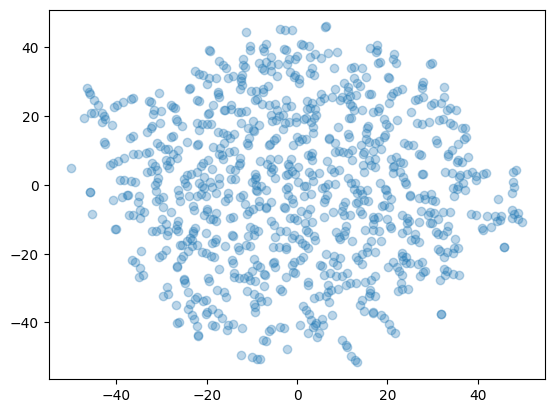

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
for score in [0,1,2,3,4]:
    avg_x = np.array(x)[df.Score-1==score].mean()
    avg_y = np.array(y)[df.Score-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.title("Amazon ratings visualized in language using t-SNE")

In [111]:
test_context = []
for i in range(CONTEXT_SIZE, len(test_story) - CONTEXT_SIZE):
    context = []
    for k in range(CONTEXT_SIZE):
        context.append(test_story[i - (CONTEXT_SIZE - k)])
    for k in range(CONTEXT_SIZE):
        context.append(test_story[i + 1 + k])
    target = test_story[i]
    test_context.append((context, target))

print('\nthe first tuple of the test data context:\n', test_context[0][0])
print('\nthe first tuple of the test data target:', test_context[0][1])


the first tuple of the test data context:
 [(4.2, 0.00139, 0.000146), (9.2, 0.0021, 0.000146), (12.5, 0.00528, 0.000146), (5.5, 0.00528, 0.000146), (5.5, 0.00528, 0.000146), (17.1, 0.00528, 0.000146), (5.5, 0.00528, 0.000109), (7.4, 0.00528, 0.000109), (4.2, 0.00528, 7.28e-05), (12.5, 0.00528, 7.28e-05)]

the first tuple of the test data target: (17.1, 0.00528, 0.000146)


In [ ]:
index = 0
context = test_context[index][0]
target = test_context[index][1] 
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector) 

print(f'Context:\n{context[:CONTEXT_SIZE]}\n{context[CONTEXT_SIZE:]}')
print(f'target: {target}')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

Context:
[(4.2, 0.00139, 0.000146), (9.2, 0.0021, 0.000146), (12.5, 0.00528, 0.000146), (5.5, 0.00528, 0.000146), (5.5, 0.00528, 0.000146)]
[(17.1, 0.00528, 0.000146), (5.5, 0.00528, 0.000109), (7.4, 0.00528, 0.000109), (4.2, 0.00528, 7.28e-05), (12.5, 0.00528, 7.28e-05)]
target: (17.1, 0.00528, 0.000146)
Prediction: (4.2, -0.00356, 0.000146)


In [88]:
def test(context_list):
    for item in context_list:
        context = item[0]
        target = item[1]
        a = model(make_context_vector(context, word_to_ix))
        print(f'pred: {ix_to_word[torch.argmax(a[0]).item()]}, target: {target}' )

shift = 1000
test(test_context[shift: shift + 6])

pred: (9.2, -2.31e-05, 9.1e-05), target: (14.3, -2.31e-05, 9.1e-05)
pred: (9.2, -2.31e-05, 9.1e-05), target: (4.2, -2.31e-05, 7.28e-05)
pred: (9.2, -0.00427, 1.82e-05), target: (14.3, -2.31e-05, 7.28e-05)
pred: (9.2, -2.31e-05, 9.1e-05), target: (14.3, -2.31e-05, 3.64e-05)
pred: (9.2, -2.31e-05, 9.1e-05), target: (14.3, -0.000377, 3.64e-05)
pred: (9.2, -2.31e-05, 9.1e-05), target: (9.2, -0.000377, 5.46e-05)


10


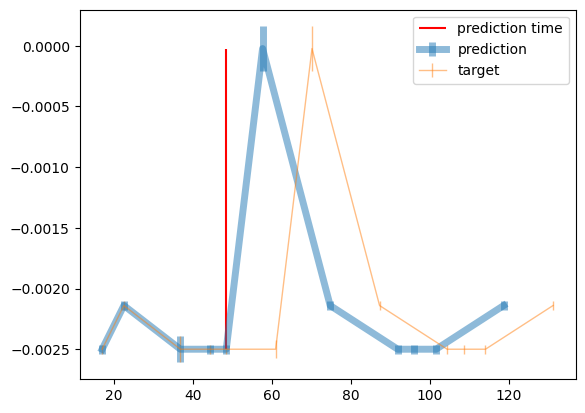

In [112]:
import matplotlib.pyplot as plt
import numpy as np

def plot_test(context_index, context_list=None):
    if context_list is None:
        context_list = test_context
    item = context_list[context_index]
    context = item[0]
    print(len(context))
    target = item[1]
    a = model(make_context_vector(context, word_to_ix))
    prediction = ix_to_word[torch.argmax(a[0]).item()]

    def plot(tar_pred, linewidth=1):
        token = context
        token.insert(CONTEXT_SIZE, prediction if tar_pred == 'prediction' else target)
        time = np.array([_[0] for _ in token]).cumsum()
        value = np.array([_[1] for _ in token])
        noise = np.array([_[2] for _ in token])
        plt.errorbar(time, value, 2 * noise, label=tar_pred, linewidth=linewidth, alpha=0.5)

    plot('prediction', linewidth=5)
    plot('target')
    time = np.array([_[0] for _ in context[:CONTEXT_SIZE]]).cumsum()
    value = np.array([_[1] for _ in context])
    plt.vlines(time[-1], min(value), max(value), label='prediction time', colors='red')

    plt.legend()
    plt.show() 

plot_test(150)
# plot_test(150, training_context)

In [85]:
print(word_count[:5])

[((17.1, 0.00528, 0.000146), 352), ((14.3, 0.00528, 0.000146), 323), ((17.1, -0.00568, 0.000146), 248), ((9.2, 0.00528, 0.000146), 236), ((12.5, 0.00528, 0.000146), 224)]
